<a href="https://colab.research.google.com/github/benson85560/yuanta/blob/main/ATC_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparation**

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime
import math as m

path = os.getcwd()
print(path)

/content


In [4]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [5]:
#Colab安裝Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-08-19 06:11:07--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-19 06:11:07--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-19 06:11:08--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

In [6]:
import talib 
from talib import abstract

## **pct_change strategy**

### for single model

In [13]:
m1b = pd.read_csv(path + '/m1b-m2.csv')
m1b = m1b.set_index(pd.to_datetime(m1b['date']))
m1b = m1b.drop('date', axis = 1)
m1b



,m1b,m2,TAIEX,m1b-m2,changing rate(m1b-m2),changing rate(Taiex)
date,,,,,,
2000-01-01,19.17,8.26,9.196505e+03,10.910,NaN,NaN
2000-02-01,19.05,8.33,9.766750e+03,10.720,-0.19,570.2450
2000-03-01,19.88,8.23,9.437228e+03,11.650,0.93,-329.5225
2000-04-01,18.68,7.89,9.364378e+03,10.790,-0.86,-72.8500
2000-05-01,14.52,7.00,8.806452e+03,7.520,-3.27,-557.9250
...,...,...,...,...,...,...
2022-03-01,10.92,8.11,1.753544e+04,2.810,-0.60,-288.5300
2022-04-01,9.81,8.12,1.703178e+04,1.690,-1.12,-503.6675
2022-05-01,8.54,7.94,1.645636e+04,0.600,-1.09,-575.4200


In [8]:
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['ATR'] = abstract.ATR(df, timeperiod = 13)
df['pct_1'] = df['close'].pct_change(1)


Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003

first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break

      
     
      # 除息日                      # BS: position, B: buy, S: sell
    if df[symbol][i] > 0 and df['ATR'][i] > df['ATR'][i-1] * 1.1 and BS == None: 
        BS = 'OK' 
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * 0.7
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.4)
        continue

        
      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity

---loading: 0050.TW---


,profit
2009-10-27,0.000000
2010-11-05,2.676182
2012-02-08,6.492976
2012-11-29,12.637670
2014-03-13,15.061915
2014-11-10,17.548316
2017-02-15,18.441164
2019-10-22,22.194826
2022-01-03,36.962758


buy:DatetimeIndex(['2010-10-27', '2011-10-28', '2012-10-30', '2013-10-29',
               '2014-10-28', '2017-02-10', '2018-02-01', '2021-01-28',
               '2022-01-25'],
              dtype='datetime64[ns]', name='Date', freq=None)
win:DatetimeIndex(['2010-11-08', '2012-02-09', '2012-11-30', '2014-03-14',
               '2014-11-11', '2017-02-16', '2019-10-23', '2022-01-04'],
              dtype='datetime64[ns]', name='Date', freq=None)
lose:DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
--------------
win ratio :0.8888888888888888


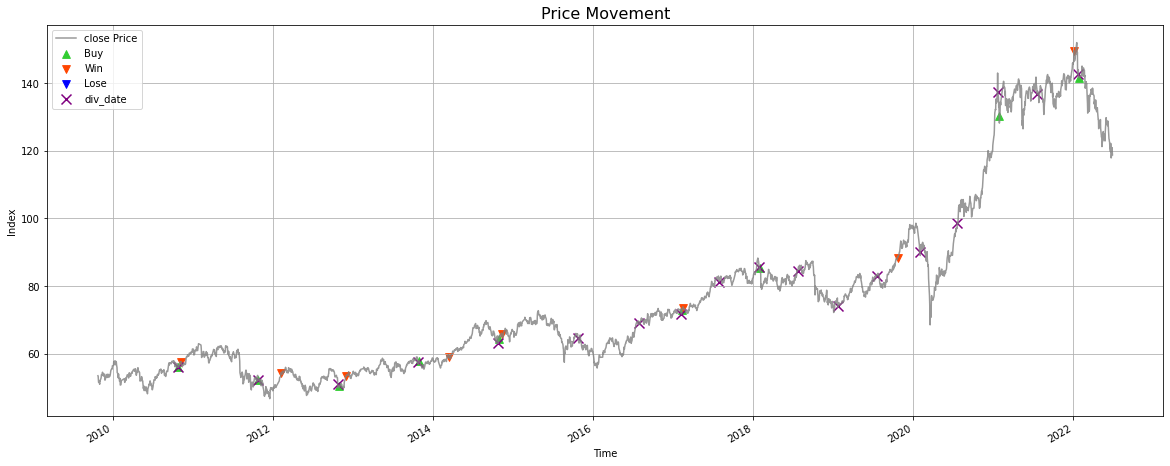

In [25]:
# 實際交易位置
List = []
for i in range(len(df)):
  if df[symbol][i] > 0:
    List.append(df.index[i])

print('buy:{}'.format(df.iloc[buy].index))
print('win:{}'.format(df.iloc[sell_win].index))
print('lose:{}'.format(df.iloc[sell_lose].index))
print('--------------')
print('win ratio :{}'.format(len(sell_win)/len(buy)))

fig, ax = plt.subplots(figsize = (20,8))
df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].loc[List].index, df['close'].loc[List],c = 'purple', label = 'div_date', marker='x', s=100)

# plt.xlim('2019-09-01', '2020-09-01')
# plt.ylim(25, 30)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

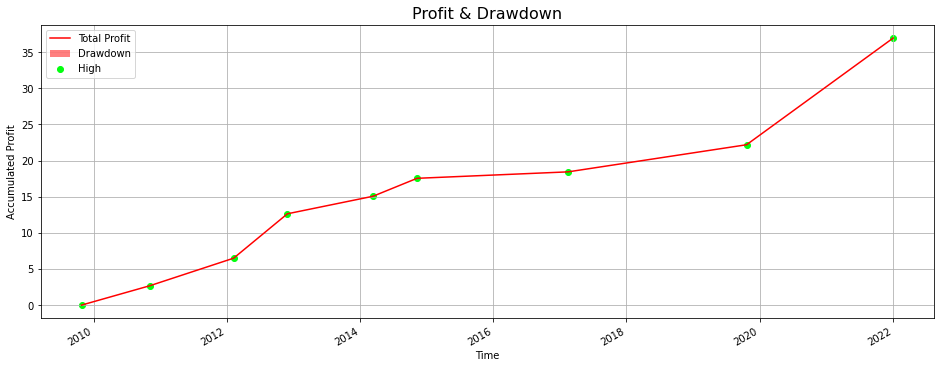

In [26]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


### for all

In [31]:
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['ATR'] = abstract.ATR(df, timeperiod = 13)
df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003

first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]

#--------# ratio cal.
win_ratio = []
err_ratio = []


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # 除息日                      # BS: position, B: buy, S: sell
    if df[symbol][i] > 0 and abs(df['ATR'][i]) > abs(df['ATR'][i-1]) * 1.1 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
        BS = 'OK' 
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * 0.7
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.4)
        continue

        
      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
win_ratio.append(len(sell_win)/len(buy))

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2009-10-26', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['SAR'] = abstract.SAR(df)
  df['ATR'] = abstract.ATR(df, timeperiod = 13)
  df['pct_1'] = df['close'].pct_change(1)

  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
  Yield = Yield.drop('Date', axis = 1)
  df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003

  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell_win = []
  sell_lose = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
          # 除息日                      # BS: position, B: buy, S: sell
      if df[symbol][i] > 0 and abs(df['ATR'][i]) > abs(df['ATR'][i-1]) * 1.1 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
          BS = 'OK' 
          continue

        # buy
      if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
          temp = df['close'][i+1] 
          tempSize = money / temp
          BS = 'B' 
          buy.append(i+1)
          stopLoss = df['SAR'][i+1] * 0.7
          stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.4)
          continue

          
        # 停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # 停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_lose.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue
      
  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

  if len(buy) == 0:
    err_ratio.append('{} is NA'.format(symbol))
  else:
    win_ratio.append(len(sell_win)/len(buy))

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


In [32]:
equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

0050.TW      132.015808
0051.TW       25.670627
0052.TW       68.999648
0053.TW       45.334821
0055.TW       39.748265
0056.TW       64.134698
006203.TW     48.037292
006204.TW     36.467611
006208.TW     30.642230
00690.TW      34.604698
00692.TW      18.456134
00701.TW      -5.844548
00712.TW     -32.767502
00713.TW      20.867009
00714.TW      20.722869
00717.TW     -24.945923
00728.TW      -1.605447
00730.TW       9.359293
00731.TW       5.604350
00733.TW       4.253110
00735.TW     -13.946970
dtype: float64 mean : 25.038479748455394


In [1]:
mean_win_ratio = sum(win_ratio)/len(win_ratio)
win_ratio, mean_win_ratio

NameError: ignored

# Optimization

* 參數：

1.   pct_change , 2.   stopEarn , 3.   stopLoss

*   training data：2008-2021





## pct_change



*   range:5, 40, 1
*   opt:35



In [30]:
opt_list = []

for pct in range(5, 40, 1):

  symbol = '0050.TW'
  print('#####----------#####')
  print(f'changing date : {pct}')

  print(f'---loading: {symbol}---')

  startDay = '2008-01-01'
  endDay = '2021-01-01'

  data = yf.Ticker(symbol)
  df = data.history(period='D', start=startDay, end=endDay)
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['SAR'] = abstract.SAR(df)
  df['pct_30'] = df['close'].pct_change(pct)
  df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
  df['pct_1'] = df['close'].pct_change(1)

  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
  Yield = Yield.drop('Date', axis = 1)
  df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003

  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell_win = []
  sell_lose = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]

  #--------# ratio cal.
  win_ratio = []
  err_ratio = []


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # 除息日                      # BS: position, B: buy, S: sell
      if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
          BS = 'OK' 
          continue

        # buy
      if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
          temp = df['close'][i+1] 
          tempSize = money / temp
          BS = 'B' 
          buy.append(i+1)
          stopLoss = df['SAR'][i+1] * 0.9
          stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
          continue

          
        # 停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # 停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_lose.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue
      
  # equity = pd.DataFrame({'profit':profit_list}, index=timeList)
  equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
  win_ratio.append(len(sell_win)/len(buy))

  ########-------------------------------------------------------------#########

  symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

  for j in range(len(symbol_list)):
    symbol = symbol_list[j]

    print(f'---loading: {symbol}---')

    data = yf.Ticker(symbol)
    df = data.history(period='D', start=startDay, end=endDay)
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df['SAR'] = abstract.SAR(df)
    df['pct_30'] = df['close'].pct_change(pct)
    # df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
    df['pct_1'] = df['close'].pct_change(1)

    Yield = pd.read_csv(path + '/yield.csv')
    Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
    Yield = Yield.drop('Date', axis = 1)
    df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003

    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    #--------# 記錄買入、賣出時間點
    buy = []
    sell_win = []
    sell_lose = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
            continue

        if i == len(df)-1: # last trading day
            break
        
            # 除息日                      # BS: position, B: buy, S: sell
        if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
            BS = 'OK' 
            continue

          # buy
        if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
            temp = df['close'][i+1] 
            tempSize = money / temp
            BS = 'B' 
            buy.append(i+1)
            stopLoss = df['SAR'][i+1] * 0.9
            stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
            continue

            
          # 停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_win.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # 停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_lose.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue
        
    pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
    equity = pd.concat([equity,pp], join='outer', axis=1)

    if len(buy) == 0:
      err_ratio.append('{} is NA'.format(symbol))
    else:
      win_ratio.append(len(sell_win)/len(buy))

  equity.fillna(0)
  df_ATC = equity.sum(axis = 0)
  ret = df_ATC.mean()
  mean_win_ratio = sum(win_ratio)/len(win_ratio)

  opt_list.append([pct, ret, mean_win_ratio])

#####----------#####
changing date : 5
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---


KeyboardInterrupt: ignored

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['pct','return', 'win_ratio'])
optResult.sort_values('win_ratio', ascending = False)

,pct,return,win_ratio
30,35,6.882115,0.837218
28,33,7.859536,0.827381
27,32,5.164780,0.814583
22,27,5.246878,0.813283
23,28,6.089577,0.806015
24,29,5.645600,0.795990
32,37,3.702065,0.791176
31,36,2.919760,0.787037
33,38,3.319609,0.779412
26,31,4.096436,0.776190


## stopEarn, StopLoss



*   earn = 11, 21, 1
*   loss = 1, 11, 1

result : earn = 14, loss = 7


In [ ]:
opt_list = []

opt_pct = 35

for Earn in range(11, 21, 1): # * 0.1 bc for loop cant count float
  for Loss in range(5, 11, 1): # same..

    symbol = '0050.TW'
    print('#####----------#####')
    print(f'changing date : {Earn}')
    print(f'changing date : {Loss}')
    print(f'---loading: {symbol}---')

    startDay = '2008-01-01'
    endDay = '2021-01-01'

    data = yf.Ticker(symbol)
    df = data.history(period='D', start=startDay, end=endDay)
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df['SAR'] = abstract.SAR(df)
    df['pct_30'] = df['close'].pct_change(opt_pct)
    df['pct_1'] = df['close'].pct_change(1)

    Yield = pd.read_csv(path + '/yield.csv')
    Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
    Yield = Yield.drop('Date', axis = 1)
    df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003

    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    #--------# 記錄買入、賣出時間點
    buy = []
    sell_win = []
    sell_lose = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]

    #--------# ratio cal.
    win_ratio = []
    err_ratio = []


    for i in range(len(df)):

        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
            continue

        if i == len(df)-1: # last trading day
            break
        
          # 除息日                      # BS: position, B: buy, S: sell
        if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
            BS = 'OK' 
            continue

          # buy
        if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
            temp = df['close'][i+1] 
            tempSize = money / temp
            BS = 'B' 
            buy.append(i+1)
            stopLoss = df['SAR'][i+1] * Loss
            stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * Earn)
            continue

            
          # 停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_win.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # 停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_lose.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue
        
    # equity = pd.DataFrame({'profit':profit_list}, index=timeList)
    equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
    win_ratio.append(len(sell_win)/len(buy))

    ########-------------------------------------------------------------#########

    symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                  '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                  '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

    for j in range(len(symbol_list)):
      symbol = symbol_list[j]

      print(f'---loading: {symbol}---')

      data = yf.Ticker(symbol)
      df = data.history(period='D', start=startDay, end=endDay)
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      df['SAR'] = abstract.SAR(df)
      df['pct_30'] = df['close'].pct_change(opt_pct)
      df['pct_1'] = df['close'].pct_change(1)

      Yield = pd.read_csv(path + '/yield.csv')
      Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
      Yield = Yield.drop('Date', axis = 1)
      df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

      fund = 100 #初始有100元本金
      money = 100 #每次投入100元
      feeRate = 0.003

      first = 0 ##除了第一筆之外，只紀錄出場的時間點
      BS = None ##紀錄現在的狀態是做多還做空
      stopEarn = 0
      stopLoss = 0

      #--------# 記錄買入、賣出時間點
      buy = []
      sell_win = []
      sell_lose = []
      #--------# 
      timeList = [] 
      profit_list = [0]
      profit_fee_list = [0]


      for i in range(len(df)):

          if first == 0:
              timeList.append(df.index[i+1])
              first = 1
              continue

          if i == len(df)-1: # last trading day
              break
          
              # 除息日                      # BS: position, B: buy, S: sell
          if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
              BS = 'OK' 
              continue

            # buy
          if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
              temp = df['close'][i+1] 
              tempSize = money / temp
              BS = 'B' 
              buy.append(i+1)
              stopLoss = df['SAR'][i+1] * Loss/10
              stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * Earn/10)
              continue

              
            # 停利
          if df['close'][i] > stopEarn and BS == 'B':
              profit = tempSize * (df['close'][i+1] - temp) 
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell_win.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # 停損
          if df['close'][i] < stopLoss and BS == 'B':
              profit = tempSize * (df['close'][i+1] - temp) 
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell_lose.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue
          
      pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
      equity = pd.concat([equity,pp], join='outer', axis=1)

      if len(buy) == 0:
        err_ratio.append('{} is NA'.format(symbol))
      else:
        win_ratio.append(len(sell_win)/len(buy))

    equity.fillna(0)
    df_ATC = equity.sum(axis = 0)
    ret = df_ATC.mean()
    mean_win_ratio = sum(win_ratio)/len(win_ratio)

    opt_list.append([Earn, Loss, ret, mean_win_ratio])



#####----------#####
changing date : 11
changing date : 5
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
changing date : 11
changing date : 6
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
--

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['Earn','Loss','ret', 'win_ratio'])
optResult.sort_values(['win_ratio', 'ret'], ascending = False)

,Earn,Loss,ret,win_ratio
20,14,7,14.465505,0.921053
18,14,5,14.436111,0.921053
19,14,6,14.424353,0.921053
14,13,7,13.627966,0.921053
8,12,7,13.622994,0.921053
12,13,5,13.598572,0.921053
6,12,5,13.593600,0.921053
13,13,6,13.586814,0.921053
7,12,6,13.581842,0.921053
2,11,7,12.802199,0.921053


In [ ]:
opt = optResult[['Earn', 'Loss', 'win_ratio']]

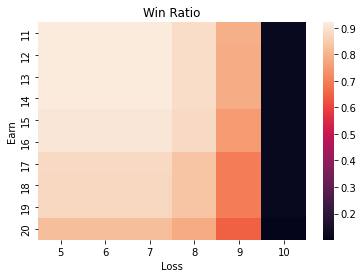

In [ ]:
import seaborn as sns

pic = opt.pivot('Earn', 'Loss', 'win_ratio')
sns.heatmap(data = pic).set(title='Win Ratio');

In [ ]:
opt_ret = optResult[['Earn', 'Loss', 'ret']]

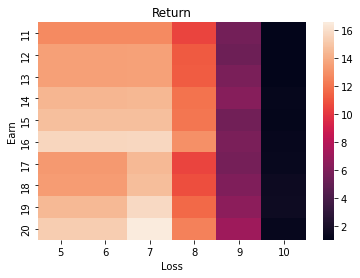

In [ ]:
pic = opt_ret.pivot('Earn', 'Loss', 'ret')
sns.heatmap(data = pic).set(title='Return');

# Opt solution

## for single model

In [ ]:
# testing

opt_pct = 35
opt_earn = 14 * 0.1
opt_loss = 7 * 0.1

symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(opt_pct)
df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 
money = 100 
feeRate = 0.003

first = 0 
BS = None 
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = []
profit_fee_list = []


for i in range(len(df)):

    # if first == 0:
    #     timeList.append(df.index[i+1])
    #     first = 1
    #     continue

    if i == len(df)-1: 
        break

      
     
      # 除息日                     
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
        BS = 'OK' 
        timeList.append(df.index[i])
        profit_list.append(0)
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i] * opt_loss
        stopEarn = df['close'][i] + (abs((df['close'][i] - df['SAR'][i])) * opt_earn)
        timeList.append(df.index[i])
        profit_list.append(0)
        continue

    # 極端值停利
    if df['pct_1'][i] > 0.07 and df['close'][i] > temp and BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue


      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 買進期間計算利潤
    if BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        timeList.append(df.index[i])
        profit_list.append(profit)

    else:
        timeList.append(df.index[i])
        profit_list.append(0)
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity

---loading: 0050.TW---


,profit
2009-10-26,0.000000
2009-10-27,0.000000
2009-10-28,0.000000
2009-10-29,0.000000
2009-10-30,0.000000
...,...
2022-06-22,39.112357
2022-06-23,39.112357
2022-06-24,39.112357
2022-06-27,39.112357


buy:DatetimeIndex(['2012-10-30', '2014-10-28', '2017-02-10', '2019-01-25',
               '2020-02-05', '2021-07-23'],
              dtype='datetime64[ns]', name='Date', freq=None)
win:DatetimeIndex(['2012-12-03', '2014-11-21', '2017-03-22', '2019-02-27',
               '2020-07-28', '2021-11-22'],
              dtype='datetime64[ns]', name='Date', freq=None)
lose:DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
--------------
win ratio :1.0


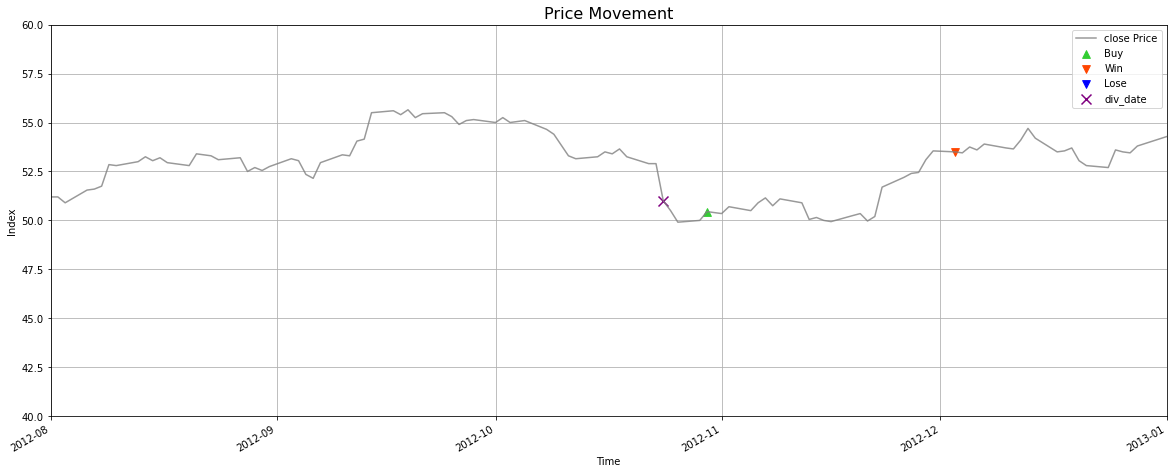

In [ ]:
# 實際交易位置
List = []
for i in range(len(df)):
  if df[symbol][i] > 0:
    List.append(df.index[i])

print('buy:{}'.format(df.iloc[buy].index))
print('win:{}'.format(df.iloc[sell_win].index))
print('lose:{}'.format(df.iloc[sell_lose].index))
print('--------------')
print('win ratio :{}'.format(len(sell_win)/len(buy)))

fig, ax = plt.subplots(figsize = (20,8))
df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].loc[List].index, df['close'].loc[List],c = 'purple', label = 'div_date', marker='x', s=100)

plt.xlim('2012-08-01', '2013-01-01')
plt.ylim(40, 60)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

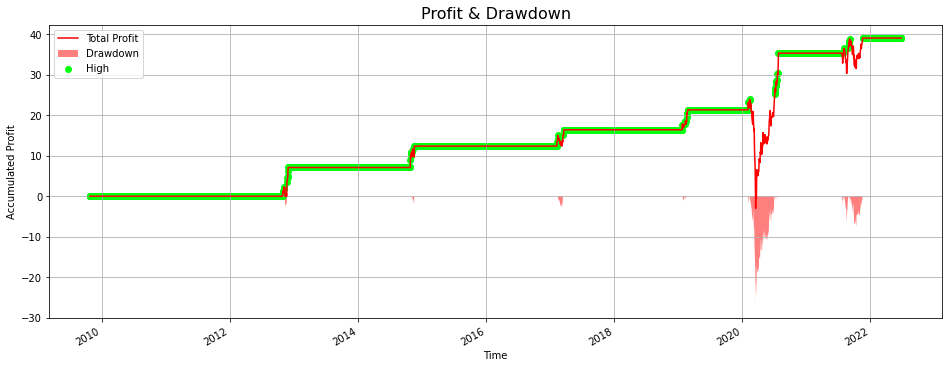

In [ ]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


##for all

0050 is weird...

In [ ]:
# testing

opt_pct = 35
opt_earn = 14 * 0.1
opt_loss = 7 * 0.1

symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(opt_pct)
df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 
money = 100 
feeRate = 0.003

first = 0 
BS = None 
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = []
profit_fee_list = []

#--------# ratio cal.
win_ratio = []
err_ratio = []


for i in range(len(df)):


    if i == len(df)-1: 
        break     
     
      # 除息日                     
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
        BS = 'OK' 
        timeList.append(df.index[i])
        profit_list.append(0)
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i] * opt_loss
        stopEarn = df['close'][i] + (abs((df['close'][i] - df['SAR'][i])) * opt_earn)
        timeList.append(df.index[i])
        profit_list.append(0)
        continue

    # 極端值停利
    if df['pct_1'][i] > 0.07 and df['close'][i] > temp and BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue


      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 買進期間計算利潤
    if BS == 'B':
        profit = tempSize * (df['close'][i] - df['close'][i-1]) 
        timeList.append(df.index[i])
        profit_list.append(profit)

    else:
        timeList.append(df.index[i])
        profit_list.append(0)
    
equity = pd.DataFrame({'0050.TW': profit_list}, index=timeList)
win_ratio.append(len(sell_win)/len(buy))

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2009-10-26', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['SAR'] = abstract.SAR(df)
  df['pct_30'] = df['close'].pct_change(opt_pct)
  # df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
  df['pct_1'] = df['close'].pct_change(1)

  df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell_win = []
  sell_lose = []
  #--------# 
  timeList = [] 
  profit_list = []
  profit_fee_list = []


  for i in range(len(df)):


      if i == len(df)-1: # last trading day
          break
        
      
        # 除息日                     
      if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
          BS = 'OK' 
          timeList.append(df.index[i])
          profit_list.append(0)
          continue

        # buy
      if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
          temp = df['close'][i] 
          tempSize = money / temp
          BS = 'B' 
          buy.append(i+1)
          stopLoss = df['SAR'][i] * opt_loss
          stopEarn = df['close'][i] + (abs((df['close'][i] - df['SAR'][i])) * opt_earn)
          timeList.append(df.index[i])
          profit_list.append(0)
          continue

      # 極端值停利
      if df['pct_1'][i] > 0.07 and df['close'][i] > temp and BS == 'B':
          profit = tempSize * (df['close'][i] - df['close'][i-1]) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i)
          timeList.append(df.index[i])
          BS=None
          continue

        # 停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i] - df['close'][i-1]) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue


        # 停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i] - df['close'][i-1]) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_lose.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # 買進期間計算利潤
      if BS == 'B':
          profit = tempSize * (df['close'][i] - df['close'][i-1]) 
          timeList.append(df.index[i])
          profit_list.append(profit)

      else:
          timeList.append(df.index[i])
          profit_list.append(0)
    
    
  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

  if len(buy) == 0:
    err_ratio.append('{} is NA'.format(symbol))
  else:
    win_ratio.append((len(sell_win)/len(buy)))

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


In [ ]:
equity

,0050.TW,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2009-10-26,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-27,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-28,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-29,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-30,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,0.0,0.0,-2.821621,0.0,0.0,0.0,0.0,-2.063679,0.0,0.0,...,0.0,0.0,0.0,0.0,0.382900,0.0,0.0,0.0,0.0,0.0
2022-06-23,0.0,0.0,-1.530367,0.0,0.0,0.0,0.0,-0.943400,0.0,0.0,...,0.0,0.0,0.0,0.0,0.510529,0.0,0.0,0.0,0.0,0.0
2022-06-24,0.0,0.0,0.047827,0.0,0.0,0.0,0.0,0.648588,0.0,0.0,...,0.0,0.0,0.0,0.0,0.255265,0.0,0.0,0.0,0.0,0.0
2022-06-27,0.0,0.0,2.247727,0.0,0.0,0.0,0.0,2.004713,0.0,0.0,...,0.0,0.0,0.0,0.0,0.765794,0.0,0.0,0.0,0.0,0.0


## Performance

In [ ]:
# equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

0050.TW      39.112357
0051.TW      37.449170
0052.TW      42.282178
0053.TW      23.855223
0055.TW      37.701672
0056.TW      50.783125
006203.TW    39.439604
006204.TW    -2.744338
006208.TW    17.643028
00690.TW      0.000000
00692.TW      9.740886
00701.TW      3.750003
00712.TW      9.064198
00713.TW      8.913353
00714.TW     15.265498
00717.TW     -2.692568
00728.TW      7.900801
00730.TW      7.349393
00731.TW      9.184117
00733.TW      0.000000
00735.TW      4.713598
dtype: float64 mean : 17.08149040395861


In [ ]:
mean_win_ratio = sum(win_ratio)/len(win_ratio)
win_ratio, err_ratio, mean_win_ratio

([1.0,
  1.0,
  0.75,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5,
  1.0,
  1.0,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  1.0,
  1.0],
 ['00690.TW is NA', '00733.TW is NA'],
 0.9254385964912281)

In [ ]:
mean_pft.pct_change()

2009-10-26         NaN
2009-10-27         NaN
2009-10-28         NaN
2009-10-29         NaN
2009-10-30         NaN
                ...   
2022-06-22   -2.076117
2022-06-23   -0.563958
2022-06-24   -1.484750
2022-06-27    4.273027
2022-06-28   -1.383320
Length: 3113, dtype: float64

In [ ]:
mean_pft.pct_change()[502] >-1000

True

In [ ]:
mean_pft.pct_change(1)[502:]
a = []
for i in range(len(mean_pft.pct_change(1))):
  if -1000 < mean_pft.pct_change(1)[i] < 1000:
    a.append(mean_pft.pct_change(1)[i])


np.array(a).std()

17.105531309735014

In [ ]:
mean_pft.std()

0.19256050447718173

Annualized return : 1.59 %
Maximum drawdown : 0.05797461577634089
Annualized volatility : 305.6803243078575 %
Sharpe Ratio: 0.005201512408756395


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

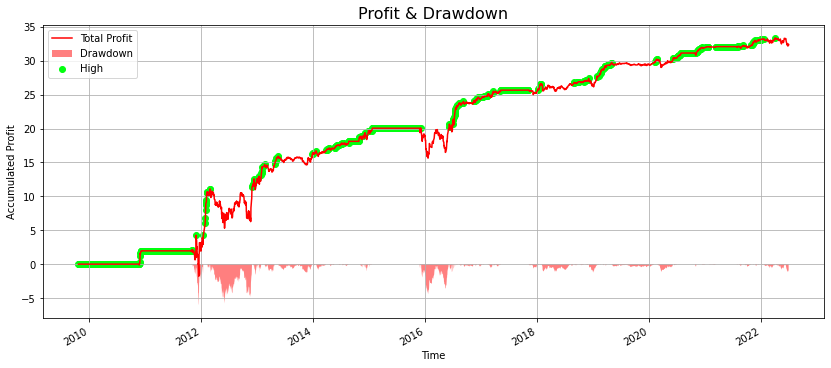

In [ ]:
ann_ret = round((((df_ATC.mean()+fund)/fund) ** (1/(2020-2010)) -1) * 100  , 3) 

mean_pft = equity.mean(axis = 1)
equity['mean_pft'] = np.cumsum(mean_pft)
equity['equity'] = equity['mean_pft'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

# 年化波動
risk = mean_pft.std()
risk_Y = (risk * 252 ** 0.5) * 100

# sharpe
sharpe_ratio = ann_ret/risk_Y

#----# 績效計算
# print('annualized return : {} %'.format(ann_ret))
print('Annualized return : {} %'.format(ann_ret))
print('Maximum drawdown : {}'.format(abs(min(equity['drawdown_percent']))))
print('Annualized volatility : {} %'.format(risk_Y))
print('Sharpe Ratio: {}'.format(sharpe_ratio))

fig, ax = plt.subplots(figsize = (14,6))

high_index = equity[equity['mean_pft'].cummax() == equity['mean_pft']].index
equity['mean_pft'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['mean_pft'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

from google.colab import files
plt.savefig("profit.png")
files.download("profit.png") 

# End